# LDA Topic Modeling with gensim

1. Algorithms/formal background
2. From text to features: preprocessing, tokens, n-grams 
3. Heuristics for the removal of stopwords 
4. Tuning of the topic number for optimal model fit 
5. Evaluating and comparing different models 
6. Visualizing and interactively exploring topic models
7. What’s the next step in the pipeline? Using the results of a topic model
8. Plotting overtime


# Preparation
We assume that you run Python 3 and have NLTK (Bird, Loper, & Klein, 2009) installed. If you use Anaconda, you have it anyway. Otherwise, use 
```
pip install nltk
```
or 
```
sudo pip install nltk
```
(or possibly pip3) in your terminal to install it.

We also assume you have `gensim` and `pyldavis` installed, if not, do so as well using pip.

Furthermore, we have to download some data for some specific NLTK modules. Download them by executing the following cell (you only have to do this once):

Bird, S., Loper, E., & Klein, E. (2009). *Natural language processing with Python*. Sebastopol, CA: O'Reilly.

In [1]:
import nltk
# nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/anne/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/anne/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/anne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Let's get started!

## Import modules
Before we start, let's import some modules that we need today. It is good practice to do so at the beginning of a script, so we'll do it right now and not later when we need them. The benefit is that you immediately see if something goes wrong (for instance, because the module is not installed).

In [3]:
import csv
import re
from glob import glob
from string import punctuation
import random
random.seed("ic2s2colgne")
from nltk.sentiment import vader
from nltk.corpus import stopwords
import nltk
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline
from datetime import datetime
print("STARTING NOW:",str(datetime.now()))

/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


STARTING NOW: 2022-09-21 13:02:19.204434


In [4]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

print(f"Your pyLDAvis version is {pyLDAvis.__version__}. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.")
assert int(pyLDAvis.__version__[0])>=3


Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.
Your pyLDAvis version is 3.3.1. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.


If you set a random seed *and* use `distributed=False` as an argument to your models, you get reprodable results

In [5]:
random.seed(1983)
np.random.seed(1983)

## Download the data
We will use a dataset by Schumacher et al. (2016). From the abstract:
> This paper presents EUSpeech, a new dataset of 18,403 speeches from EU leaders (i.e., heads of government in 10 member states, EU commissioners, party leaders in the European Parliament, and ECB and IMF leaders) from 2007 to 2015. These speeches vary in sentiment, topics and ideology, allowing for fine-grained, over-time comparison of representation in the EU. The member states we included are Czech Republic, France, Germany, Greece, Netherlands, Italy, Spain, United Kingdom, Poland and Portugal.

Schumacher, G, Schoonvelde, M., Dahiya, T., Traber, D, & de Vries, E. (2016): *EUSpeech: a New Dataset of EU Elite Speeches*. [doi:10.7910/DVN/XPCVEI](http://dx.doi.org/10.7910/DVN/XPCVEI)

Download and unpack the following file:
```
speeches_csv.tar.gz
```

In the .tar.gz file, you find a .zip file. Extract the whole folder to your home directory.
See below a screenshot of how this looks like in Lubuntu (double-click on "speeches_csv.zip" in the left window, then the right window will open. Click on "Extract")

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


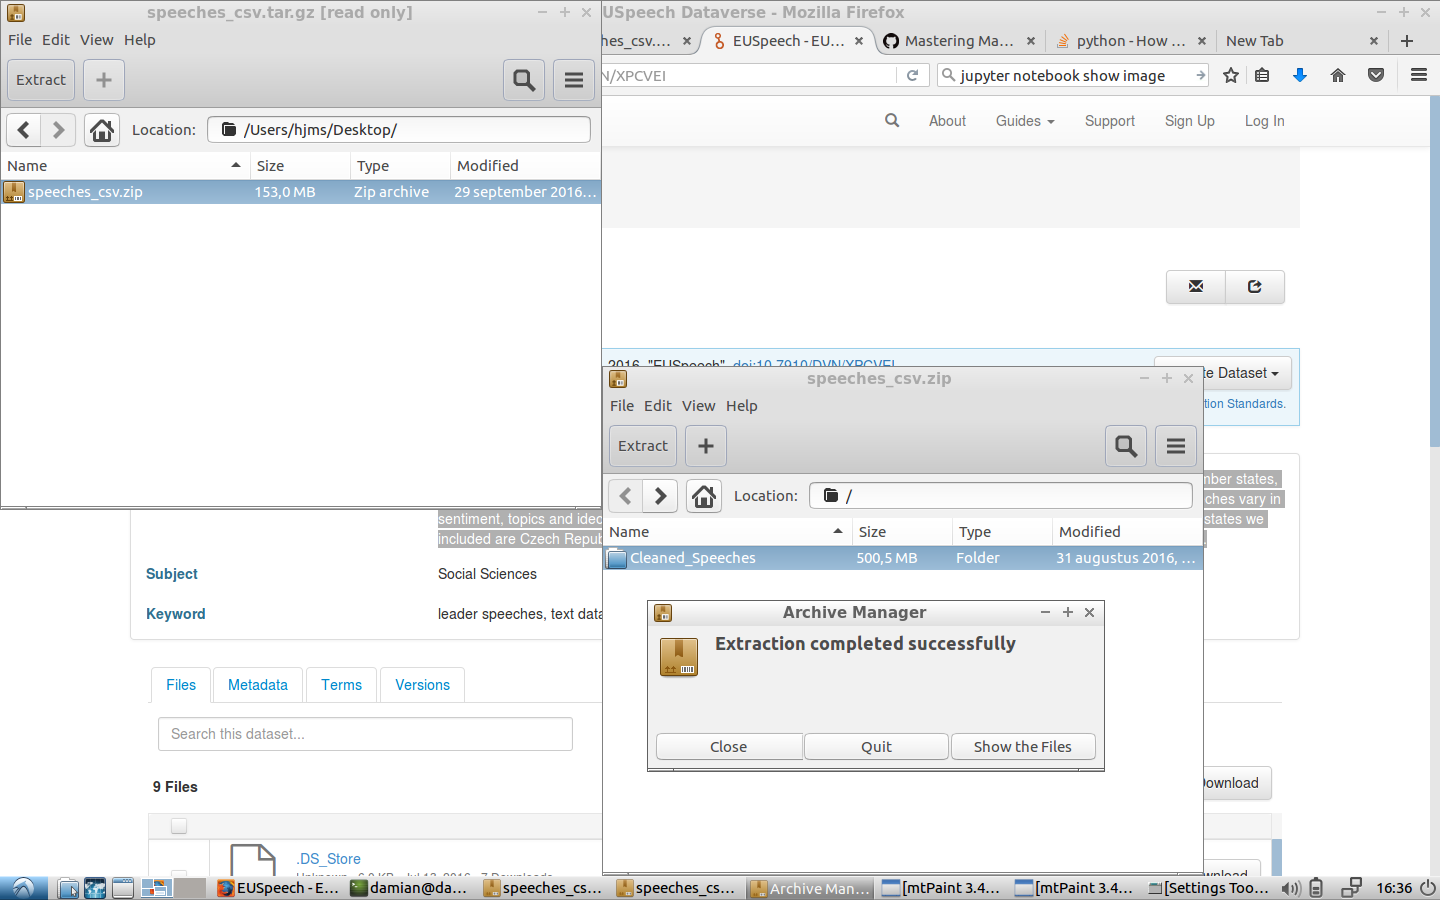

In [5]:
from IPython.display import Image
Image("https://github.com/damian0604/bdaca/raw/master/ipynb/euspeech_download.png")

Let's have a look at the files we downloaded.

**NB: This command line magic only works on Linux and MacOS**

In [6]:
%ls ~/Downloads/Cleaned_Speeches/

Speeches_ALDE_Cleaned.csv*       Speeches_GR_Cleaned.csv*
Speeches_CZ_Cleaned.csv*         Speeches_IMF_Cleaned.csv*
Speeches_DE_Cleaned.csv*         Speeches_IT_Cleaned.csv*
Speeches_ECB_Cleaned.csv*        Speeches_NL_Cleaned.csv*
Speeches_EC_Cleaned.csv*         Speeches_PL_Cleaned.csv*
Speeches_ECR_Cleaned.csv*        Speeches_PO_Cleaned.csv*
Speeches_EP_Cleaned.csv*         Speeches_SP_Cleaned.csv*
Speeches_EUCouncil_Cleaned.csv*  Translated/
Speeches_FR_Cleaned.csv*


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Let's start!
Let's retrieve a list of all speeches from one of the files. Of course, we could also loop over all the files...

In [6]:
#filelist = glob('Cleaned_Speeches/Speeches_*_Cleaned.csv')
# instead of all speeches, to speed up things, we are focusing on speeches from the Netherlands only
filelist = glob('speeches_UK_Cleaned.csv')
print(filelist)
speeches_eng=[]
for fn in filelist:
    with open(fn) as fi:
        reader=csv.reader(fi)
        for row in reader:
            if row[7]=='en':   # only include english-language speches; we might as well choose 'nl' or 'fr'
                speeches_eng.append(row[5])

['speeches_UK_Cleaned.csv']


In [7]:
len(speeches_eng)

787

In [9]:
# To speed things up, we could also sample some speeches. 
# speeches = random.sample(speeches,100)
# len(speeches)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
speeches_eng[0][:500]

'<p>This European Council has focused on 3 issues – the UK renegotiation, migration and terrorism.</p><p>I talked about the renegotiation last night and I will come back to it shortly – but first the other 2 issues.</p><p>Yesterday afternoon, we discussed the ongoing migration crisis facing Europe.</p><p>Even with the onset of winter, there are still many migrants coming to Europe – with around 5,000 arriving via the eastern Mediterranean route each day.</p><p>Britain has its own strict border co'

# 2. From text to features: preprocessing, tokens, n-grams 
## General approach

From a machine-learning perspective, one could argue that all information in a text might be useful information. However, we are interested in getting *interpretable* topics, so even if for instance the use of specific HTML tags would help us distinguising between some documents, we want to get rid of them. More in general, we start by cleaning up a bit to get only 'real' text.

### Some typical clean-up steps:

In [9]:
speeches_eng=[speech.replace('<p>',' ').replace('</p>',' ') for speech in speeches_eng]   #remove HTML tags
speeches_eng=["".join([l for l in speech if l not in punctuation]) for speech in speeches_eng]  #remove punctuation
speeches_eng=[speech.lower() for speech in speeches_eng]  # convert to lower case
speeches_eng=[" ".join(speech.split()) for speech in speeches_eng]   # remove double spaces by splitting the strings into words and joining these words again

Let's look at the first speech to check everything's fine.

In [10]:
speeches_eng[0][:500]

'this european council has focused on 3 issues – the uk renegotiation migration and terrorism i talked about the renegotiation last night and i will come back to it shortly – but first the other 2 issues yesterday afternoon we discussed the ongoing migration crisis facing europe even with the onset of winter there are still many migrants coming to europe – with around 5000 arriving via the eastern mediterranean route each day britain has its own strict border controls which apply to everyone atte'

However, as with other unsupervised machine learning techniques, we are not really interesting a long string of text. We rather want to have each document being represented by a set of *features*. To this end, `gensim` has a finciton `doc2bow` that converts a list of words (tokens) to `(token_id, token_count)` tuples. 

In [12]:
# to avoid messing things up, I'll call all objects relating to our first model _m1
ldainput_m1 = [speech.split() for speech in speeches_eng]           # convert all strings to list of words
id2word_m1 = corpora.Dictionary(ldainput_m1)                        # assign a token_id to each word
ldacorpus_m1 = [id2word_m1.doc2bow(doc) for doc in ldainput_m1]     # represent each speech by (token_id, token_count) tuples

Let's just run a simple LDA on this to check out whether it works. We specify the corpus (in wich each document is represented by a `(token_id, token_count)` tuple), the table to translate the token_id's back to words, and the number of topics we want. 

In [13]:
lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10)
lda_m1.print_topics()
                            

[(0,
  '0.046*"and" + 0.036*"the" + 0.032*"to" + 0.026*"of" + 0.025*"a" + 0.018*"in" + 0.017*"is" + 0.017*"we" + 0.015*"that" + 0.014*"i"'),
 (1,
  '0.052*"the" + 0.038*"to" + 0.025*"we" + 0.024*"of" + 0.023*"and" + 0.017*"a" + 0.017*"that" + 0.015*"is" + 0.013*"in" + 0.011*"i"'),
 (2,
  '0.046*"the" + 0.034*"and" + 0.033*"to" + 0.025*"of" + 0.021*"a" + 0.021*"is" + 0.019*"we" + 0.018*"in" + 0.018*"that" + 0.011*"i"'),
 (3,
  '0.056*"the" + 0.038*"to" + 0.034*"and" + 0.026*"that" + 0.024*"a" + 0.024*"of" + 0.021*"we" + 0.018*"in" + 0.015*"i" + 0.014*"is"'),
 (4,
  '0.064*"the" + 0.038*"to" + 0.029*"and" + 0.029*"of" + 0.028*"that" + 0.023*"in" + 0.018*"is" + 0.017*"we" + 0.014*"a" + 0.011*"i"'),
 (5,
  '0.053*"the" + 0.038*"and" + 0.035*"to" + 0.024*"of" + 0.022*"that" + 0.020*"in" + 0.018*"a" + 0.016*"we" + 0.015*"i" + 0.014*"is"'),
 (6,
  '0.047*"the" + 0.042*"and" + 0.033*"to" + 0.023*"of" + 0.022*"in" + 0.022*"we" + 0.018*"that" + 0.015*"i" + 0.014*"a" + 0.013*"is"'),
 (7,
  '0.043

## Stopwords
We immediately see that the result of our first LDA doesn't make much sense: We see only stopwords. 


### Explicit stopword removal
The most straightforward approach is to use a pre-existing list with stopwords, possibly with the addition of some own, case-specific words. We then split up each speech in words, and only if a word is not on the stopwordlist, we keep it and join it with the previous and next word using a space.

In [14]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line

speeches_eng_clean = [" ".join([w for w in speech.split() if w not in mystopwords]) for speech in speeches_eng]

In [15]:
speeches_eng_clean[0][:500]

'european council focused 3 issues – uk renegotiation migration terrorism talked renegotiation last night come back shortly – first 2 issues yesterday afternoon discussed ongoing migration crisis facing europe even onset winter still many migrants coming europe – around 5000 arriving via eastern mediterranean route day britain strict border controls apply everyone attempting enter united kingdom every day border controls helping keep us safe outside schengen ready help european partners secure bo'

Let's check whether this looks better:

In [16]:
ldainput_m2 = [speech.split() for speech in speeches_eng_clean]      # speechesclean instead of speeches
id2word_m2 = corpora.Dictionary(ldainput_m2)                       
ldacorpus_m2 = [id2word_m2.doc2bow(doc) for doc in ldainput_m2]  
lda_m2 = models.LdaModel(ldacorpus_m2, id2word=id2word_m2, num_topics=10)
lda_m2.print_topics(num_words=5)

[(0,
  '0.012*"people" + 0.011*"think" + 0.006*"–" + 0.006*"world" + 0.005*"want"'),
 (1,
  '0.013*"people" + 0.007*"think" + 0.007*"world" + 0.006*"–" + 0.006*"make"'),
 (2,
  '0.013*"people" + 0.010*"think" + 0.005*"world" + 0.005*"government" + 0.004*"need"'),
 (3,
  '0.008*"people" + 0.007*"minister" + 0.006*"think" + 0.006*"prime" + 0.006*"also"'),
 (4,
  '0.011*"think" + 0.008*"people" + 0.005*"make" + 0.005*"it’s" + 0.005*"–"'),
 (5,
  '0.009*"people" + 0.008*"world" + 0.007*"think" + 0.006*"minister" + 0.006*"also"'),
 (6,
  '0.009*"people" + 0.007*"think" + 0.006*"world" + 0.006*"countries" + 0.005*"–"'),
 (7,
  '0.012*"people" + 0.009*"think" + 0.006*"–" + 0.006*"minister" + 0.005*"country"'),
 (8,
  '0.008*"people" + 0.007*"think" + 0.007*"–" + 0.007*"prime" + 0.006*"country"'),
 (9,
  '0.009*"think" + 0.009*"people" + 0.008*"–" + 0.007*"want" + 0.006*"minister"')]

### TF-IDF scores instead of word counts as features
Explicitly removing stopwords is a common practice and often very useful. We shouldn't forget, though, that there are some problematic aspects to it as well
- It is kind of arbitrary what is on the stopword list and what now
- Depending on the research question one is interested in, it might differ what words are 'meaningful'
- Although the list is meant to consist of words that occur with a high frequency in all texts, it is not based on actual frequencies in the corpus but set a priori.
A different approach would therefore be to simply use (a) the frequency of each word in the corpus and (b) the number of documents in which the document occurs. 
In other words: If we use tf-idf scores (term frequency weighed by the inverse document frequncy) instead of raw word counts as featues, the stopwords should disappear automatically:

In [17]:
ldacorpus_m3 = ldacorpus_m1       # reuse corpus from Model 1 
id2word_m3 = id2word_m1           # and thus, also use id2word-mapping
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)
lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

[(0, '0.001*"–" + 0.001*"you" + 0.000*"got" + 0.000*"banks" + 0.000*"global"'),
 (1,
  '0.001*"israel" + 0.001*"–" + 0.000*"palestinian" + 0.000*"you" + 0.000*"it’s"'),
 (2, '0.001*"–" + 0.001*"we’re" + 0.000*"you" + 0.000*"got" + 0.000*"bill"'),
 (3,
  '0.001*"–" + 0.001*"global" + 0.000*"afghanistan" + 0.000*"it’s" + 0.000*"you"'),
 (4, '0.001*"–" + 0.001*"nhs" + 0.001*"think" + 0.000*"you" + 0.000*"it’s"'),
 (5,
  '0.001*"–" + 0.001*"afghanistan" + 0.001*"it’s" + 0.001*"you" + 0.001*"think"'),
 (6,
  '0.001*"–" + 0.001*"business" + 0.000*"think" + 0.000*"it’s" + 0.000*"we’re"'),
 (7,
  '0.001*"–" + 0.000*"pakistan" + 0.000*"it’s" + 0.000*"afghanistan" + 0.000*"think"'),
 (8, '0.001*"–" + 0.001*"nhs" + 0.001*"global" + 0.001*"you" + 0.000*"think"'),
 (9,
  '0.001*"–" + 0.000*"ireland" + 0.000*"northern" + 0.000*"think" + 0.000*"afghanistan"')]

## Filtering extremes
Just as we don't want to include words that are all over the place and do little to distinguish documents, we also do not want to include words that virtually never occur. If among millions of words, a word occurs exactly one time, it might be simply a spelling mistake. But even if it is not, it does not help us to infer topics across documents. 

Also in purely pragmatic terms, it makes sense to remove unneccessary features to speed up the analysis process.


In [18]:
id2word_m4 = corpora.Dictionary(ldainput_m1)           # reuse input from M1     

id2word_m4.filter_extremes(no_below=5, no_above=0.5)   # do not consider all words that occur in less than n=5 documents
                                                       # or in more than 50% of all documents.

ldacorpus_m4 = [id2word_m4.doc2bow(doc) for doc in ldainput_m1]
tfidfcorpus_m4 = models.TfidfModel(ldacorpus_m4)
lda_m4 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m4[ldacorpus_m4],id2word=id2word_m4,num_topics=10, distributed=False, random_state=42) 
lda_m4.print_topics(num_words=5)

[(0,
  '0.001*"–" + 0.001*"palestinian" + 0.001*"ireland" + 0.001*"european" + 0.001*"nhs"'),
 (1,
  '0.002*"–" + 0.001*"iraq" + 0.001*"syria" + 0.001*"eu" + 0.001*"speaker"'),
 (2,
  '0.001*"–" + 0.001*"afghanistan" + 0.001*"european" + 0.001*"relationship" + 0.001*"speaker"'),
 (3,
  '0.002*"–" + 0.001*"afghanistan" + 0.001*"we’re" + 0.001*"afghan" + 0.001*"oil"'),
 (4,
  '0.002*"–" + 0.001*"european" + 0.001*"we’re" + 0.001*"global" + 0.001*"union"'),
 (5,
  '0.003*"–" + 0.001*"nhs" + 0.001*"afghanistan" + 0.001*"care" + 0.001*"ireland"'),
 (6,
  '0.002*"afghanistan" + 0.001*"pakistan" + 0.001*"–" + 0.001*"afghan" + 0.001*"nhs"'),
 (7,
  '0.002*"–" + 0.001*"bill" + 0.001*"wales" + 0.001*"ireland" + 0.001*"social"'),
 (8,
  '0.002*"–" + 0.001*"global" + 0.001*"iran" + 0.001*"question" + 0.001*"we’re"'),
 (9,
  '0.002*"–" + 0.001*"global" + 0.001*"european" + 0.001*"afghanistan" + 0.001*"trade"')]

## Other preprocessing ideas

### Stemming
Stemming can be useful to avoid that 'economics', 'economic', and 'economy' are seen as different concepts by the topic model. In practice, however, standard stemming algorithms are far from perfect:

In [19]:
stemmer = nltk.stem.snowball.EnglishStemmer()
speeches_eng_stemmed = [" ".join([stemmer.stem(word) for word in speech.split()]) for speech in speeches_eng]
speeches_eng_stemmed[0][:500]

'this european council has focus on 3 issu – the uk renegoti migrat and terror i talk about the renegoti last night and i will come back to it short – but first the other 2 issu yesterday afternoon we discuss the ongo migrat crisi face europ even with the onset of winter there are still mani migrant come to europ – with around 5000 arriv via the eastern mediterranean rout each day britain has it own strict border control which appli to everyon attempt to enter the unit kingdom and everi day those'

### Parsing and retaining only nouns and adjectives
Depending on the specific use case at hand, one might discover that some parts of speech (POS) are more informative than others. We could, for instance, create a topic model based on only the nouns and adjectives in a text, disregarding everything else. 
Look at the NLTK documentation to find out what each code means (e.g., 'NN' is 'noun') 

In [20]:
speeches_eng_nounsadj=[]
for speech in speeches_eng:
    tokens = nltk.word_tokenize(speech)
    tagged = nltk.pos_tag(tokens)
    cleanspeech = ""
    for element in tagged:
        if element[1] in ('NN','NNP','JJ'):
            cleanspeech=cleanspeech+element[0]+" "
    speeches_eng_nounsadj.append(cleanspeech)

In [21]:
speeches_eng_nounsadj[0][:500]

'european council uk renegotiation migration terrorism i renegotiation last night i other yesterday afternoon ongoing migration crisis onset winter many – eastern mediterranean route day britain own strict border everyone united kingdom day border safe outside schengen ready european start united kingdom comprehensive approach root migration crisis – vast europe ’ £12 humanitarian assistance syrian conflict hms enterprise police mediterranean ’ practical assistance registering fingerprinting gree'

### Using ngrams as features
Topic models follow a bag-of-words approach, meaning they do not take word order into account. However, sometimes we want to be able to do so to a limited extend: The "white house" is something else than a "house with a white wall", even though both strings contain the words 'white' and 'house'. We can do so by joining adjacent words together in so-called bigrams (or trigrams, if we take three words).

In [22]:
speeches_eng_bigrams = [["_".join(tup) for tup in nltk.ngrams(speech.split(),2)] for speech in speeches_eng_clean]

In [23]:
speeches_eng_bigrams[0][100:]

['police_officers',
 'officers_mediterranean',
 'mediterranean_go',
 'go_traffickers',
 'traffickers_it’s',
 'it’s_offered',
 'offered_practical',
 'practical_assistance',
 'assistance_help',
 'help_registering',
 'registering_fingerprinting',
 'fingerprinting_migrants',
 'migrants_countries',
 'countries_land',
 'land_like',
 'like_greece',
 'greece_italy',
 'italy_indeed',
 'indeed_provided',
 'provided_technical',
 'technical_expertise',
 'expertise_european',
 'european_asylum',
 'asylum_support',
 'support_office',
 'office_country',
 'country_summit',
 'summit_discussed',
 'discussed_importance',
 'importance_implementing',
 'implementing_measures',
 'measures_previously',
 'previously_agreed',
 'agreed_back',
 'back_summer',
 'summer_frank',
 'frank_discussions',
 'discussions_countries',
 'countries_committed',
 'committed_resettle',
 'resettle_22000',
 '22000_refugees',
 'refugees_syria',
 'syria_2',
 '2_years',
 'years_relocate',
 'relocate_160000',
 '160000_migrants',
 'migr

In [24]:
# maybe we want both unigrams and bigrams in the feature set?
assert len(speeches_eng_clean)==len(speeches_eng_bigrams)
speeches_eng_uniandbigrams = []
for a,b in zip([speech.split() for speech in speeches_eng_clean],speeches_eng_bigrams):
    speeches_eng_uniandbigrams.append(a + b)

In [25]:
len(speeches_eng_uniandbigrams[6]),len(speeches_eng_bigrams[6]),len(speeches_eng_clean[6].split())

(2283, 1141, 1142)

In [26]:
id2word_m5 = corpora.Dictionary(speeches_eng_uniandbigrams)                       
id2word_m5.filter_extremes(no_below=5, no_above=0.5)
ldacorpus_m5 = [id2word_m5.doc2bow(doc) for doc in speeches_eng_uniandbigrams]
tfidfcorpus_m5 = models.TfidfModel(ldacorpus_m5)
lda_m5 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],id2word=id2word_m5,num_topics=10)
lda_m5.print_topics(num_words=5)

[(0,
  '0.000*"–" + 0.000*"we’re" + 0.000*"europe" + 0.000*"libya" + 0.000*"business"'),
 (1,
  '0.001*"–" + 0.000*"northern_ireland" + 0.000*"ireland" + 0.000*"northern" + 0.000*"european"'),
 (2,
  '0.001*"–" + 0.000*"we’re" + 0.000*"afghanistan" + 0.000*"nhs" + 0.000*"afghan"'),
 (3,
  '0.001*"–" + 0.000*"global" + 0.000*"business" + 0.000*"israel" + 0.000*"afghanistan"'),
 (4,
  '0.001*"–" + 0.000*"afghanistan" + 0.000*"afghan" + 0.000*"global" + 0.000*"nhs"'),
 (5,
  '0.001*"–" + 0.000*"global" + 0.000*"we’re" + 0.000*"european" + 0.000*"question"'),
 (6,
  '0.001*"–" + 0.000*"afghanistan" + 0.000*"pakistan" + 0.000*"banks" + 0.000*"afghan"'),
 (7,
  '0.001*"–" + 0.000*"turkey" + 0.000*"oil" + 0.000*"global" + 0.000*"energy"'),
 (8,
  '0.000*"afghanistan" + 0.000*"–" + 0.000*"pakistan" + 0.000*"afghan" + 0.000*"iraq"'),
 (9,
  '0.001*"–" + 0.000*"afghanistan" + 0.000*"banks" + 0.000*"system" + 0.000*"we’re"')]

## Summing up
While there are different ways to achieve the desired results and different modules to help you with it (writing from scratch, NLTK, but also gensim.utils), these are some steps to consider when transforming texts to feature sets for topic modeling (recall that not all of them might be neccessary of even diserable, depending on the use case):

- transforming to lowercase
- removing stopwords
- stemming
- POS-tagging (and removing unwanted elements)
- filtering extremely common and extremely uncommon words
- ngrams and/or unigrams as features?
- raw frequencies or TF-IDF scores as features?



# 5. Evaluating and comparing different models

## Topic coherence
We can calculate the Umass topic coherence for each topic. See Mimno, Wallach, Talley, Leenders, McCallum: Optimizing Semantic Coherence in Topic Models, CEMNLP 2011

In [31]:
# print coherence per topic:
lda_m5.top_topics(ldacorpus_m5)

[([(0.00070033077, '–'),
   (0.00040697507, 'afghanistan'),
   (0.00039948628, 'pakistan'),
   (0.00033455828, 'banks'),
   (0.00031662232, 'afghan'),
   (0.00029451706, 'we’re'),
   (0.00028336342, 'question'),
   (0.00027302734, 'health'),
   (0.00026202208, 'european'),
   (0.00025307998, 'we’ve_got'),
   (0.00023813653, 'actually'),
   (0.00023052262, 'global'),
   (0.00022534336, 'tax'),
   (0.00022262019, 'lending'),
   (0.0002212916, 'money'),
   (0.00021548482, 'businesses'),
   (0.00021344014, 'climate'),
   (0.00021223915, 'climate_change'),
   (0.00021198936, 'health_service'),
   (0.00020985019, 'jobs')],
  -0.9480340003643365),
 ([(0.0005950625, '–'),
   (0.00028565878, 'global'),
   (0.000274766, 'we’re'),
   (0.00027186316, 'european'),
   (0.00025702827, 'question'),
   (0.00025669148, 'eu'),
   (0.00024872864, 'banks'),
   (0.00024031733, 'business'),
   (0.0002383545, 'businesses'),
   (0.00023689565, 'oil'),
   (0.00022648867, 'iran'),
   (0.00021946587, 'system'),
 

In [32]:
# Or: overall coherence
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`
cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1, dictionary= id2word_m1, coherence='u_mass')  
naivecoh = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
cleancoh = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
tfidfcoh = cm3.get_coherence()
cm4 = models.CoherenceModel(model=lda_m4, corpus=tfidfcorpus_m4[ldacorpus_m4], dictionary= id2word_m4, coherence='u_mass')
tfidffiltercoh = cm4.get_coherence()
print("Coherence of naive model = {}\nCoherence of clean model = {}\nCoherence of tf-idf model = {}\nCoherence of tf-idf model without extreme words {}".format(naivecoh, cleancoh, tfidfcoh,tfidffiltercoh))
print("NB: Note that it may not make too much sense to compare these vaues across different corpora")

Coherence of naive model = -0.03593472682100688
Coherence of clean model = -0.21103897617331277
Coherence of tf-idf model = -0.8154307688706082
Coherence of tf-idf model without extreme words -1.231415715388437
NB: Note that it may not make too much sense to compare these vaues across different corpora


In [33]:
lda_m4_bad = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m4_bad, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

lda_m4_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

-0.8924791074515619
-8.867373403663612


In [34]:
lda_m4_bad.top_topics(tfidfcorpus_m4[ldacorpus_m4])

[([(0.0016460322, '–'),
   (0.0009086926, 'trade'),
   (0.0009071483, 'afghanistan'),
   (0.00088472187, 'global'),
   (0.0007725676, 'question'),
   (0.0007623701, 'president'),
   (0.0007200213, 'investment'),
   (0.0007024104, 'european'),
   (0.0006925832, 'europe'),
   (0.00068826467, 'g20'),
   (0.0006581835, 'eu'),
   (0.00062710524, 'business'),
   (0.0006239843, 'banks'),
   (0.0006197508, 'money'),
   (0.00061572745, 'system'),
   (0.00059956365, 'we’re'),
   (0.0005988957, 'oil'),
   (0.00058237265, 'businesses'),
   (0.0005792864, 'society'),
   (0.0005536466, 'jobs')],
  -0.7381569117362555),
 ([(0.0018436406, '–'),
   (0.0008477776, 'question'),
   (0.0008463716, 'trade'),
   (0.00071718503, 'we’re'),
   (0.000696823, 'afghanistan'),
   (0.0006869692, 'europe'),
   (0.0006786402, 'society'),
   (0.0006786092, 'jobs'),
   (0.00065357646, 'global'),
   (0.0006356246, 'pakistan'),
   (0.00061480724, 'investment'),
   (0.0006134833, 'energy'),
   (0.0006131798, 'system'),
   

In [35]:
lda_m4_good.top_topics(tfidfcorpus_m4[ldacorpus_m4])

[([(0.0036540818, '–'),
   (0.0020202405, 'we’re'),
   (0.0016960973, 'business'),
   (0.0015849654, 'businesses'),
   (0.0014347405, 'schools'),
   (0.0013394337, 'tax'),
   (0.0013031042, 'global'),
   (0.0012893039, 'system'),
   (0.0012874446, 'young'),
   (0.0012548995, 'public'),
   (0.0012252531, 'investment'),
   (0.0012185154, 'school'),
   (0.0012083492, 'jobs'),
   (0.0011859408, 'money'),
   (0.0011637905, 'children'),
   (0.0011602413, 'education'),
   (0.0011448456, 'companies'),
   (0.001092764, 'energy'),
   (0.0010907839, 'health'),
   (0.0010650348, 'wales')],
  -0.825913780742728),
 ([(0.0024818096, '–'),
   (0.00243109, 'european'),
   (0.002158755, 'afghanistan'),
   (0.0018499225, 'president'),
   (0.0018390224, 'eu'),
   (0.0017729797, 'pakistan'),
   (0.0017188154, 'eurozone'),
   (0.0016369994, 'g20'),
   (0.0016301699, 'europe'),
   (0.0015556657, 'agreed'),
   (0.0015483983, 'nuclear'),
   (0.0014543439, 'union'),
   (0.0014345037, 'mr'),
   (0.0014320333, 's

In [36]:
lda_m3.top_topics?

Signature:
lda_m3.top_topics(
    corpus=None,
    texts=None,
    dictionary=None,
    window_size=None,
    coherence='u_mass',
    topn=20,
    processes=-1,
)
Docstring:
Get the topics with the highest coherence score the coherence for each topic.

Parameters
----------
corpus : iterable of list of (int, float), optional
    Corpus in BoW format.
texts : list of list of str, optional
    Tokenized texts, needed for coherence models that use sliding window based (i.e. coherence=`c_something`)
    probability estimator .
dictionary : :class:`~gensim.corpora.dictionary.Dictionary`, optional
    Gensim dictionary mapping of id word to create corpus.
    If `model.id2word` is present, this is not needed. If both are provided, passed `dictionary` will be used.
window_size : int, optional
    Is the size of the window to be used for coherence measures using boolean sliding window as their
    probability estimator. For 'u_mass' this doesn't matter.
    If None - the default window sizes a

In [37]:
a= cm1.get_coherence_per_topic()

In [38]:
a[2]

-0.04046925979595568

# 6. Visualizing and interactively exploring topic models
A great tool for interactively exploring topicmodels is pyLDAvis.
pyLDAvis can estimate its own topic models, but it als has a nice function called `gensim.prepare`, which you can use to visualize the model you already estimated with gensim.

In [39]:
vis_data = gensimvis.prepare(lda_m5,ldacorpus_m5,id2word_m5)
pyLDAvis.display(vis_data)

/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/mi

# 7. What’s the next step in the pipeline? Using the results of a topic model

Until know, we have mainly considered the interpretation of the topics themselves. While it can indeed be interesting to use topic models to summarize and interpret large corpora, this is usually not where social scientists stop: We want to relate the topics back to documents to say something about which topics occur in which documents.

## Saving topic scores to a file
Somewhat similar to factor analysis and principal component analysis, where one can also store factor scores that indicate how high a specific case scores on each of the factors that were identified, for each document, we can estimate a score for each of the topics we identified.

To do so, we can simply call the `.inference()` method on the model we estimated. 

In [40]:
scoresperdoc=lda_m5.inference(ldacorpus_m5)

In [43]:
len(scoresperdoc[0])

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


132

We could do a lot of different stuff with the resulting matrix, in which each row represents one of the documents and each row consists of one score for each topic.
For example, we just could create a tab-separated file:

In [41]:
with open("topicscores.tsv","w",encoding="utf-8") as fo:
    for row in scoresperdoc[0]:
       fo.write("\t".join(["{:0.3f}".format(score) for score in row]))
       fo.write("\n")

... or we put it into a Pandas dataframe

In [42]:
df = pd.DataFrame.from_records(scoresperdoc[0])
df

,0,1,2,3,4,5,6,7,8,9
0,0.100020,981.189453,0.100025,0.100018,284.099548,0.100028,59.533031,0.100024,0.100020,0.100023
1,0.100022,55.313911,0.100027,110.918274,225.716858,0.100024,26.646103,0.100026,0.100021,14.267735
2,2.667879,80.560066,34.392067,0.100019,163.008804,0.100023,15.872425,0.100020,56.621243,0.100027
3,0.100022,0.100027,0.100026,0.100019,2310.753174,0.100026,232.481400,0.100025,0.100029,14.296118
4,0.100019,397.603088,0.100021,0.100017,17.210438,0.100021,0.100025,0.100016,0.100019,0.100023
...,...,...,...,...,...,...,...,...,...,...
782,0.100017,0.100019,0.100014,0.100014,0.100027,0.100017,0.100018,104.173637,0.100012,0.100028
783,0.100028,3.750030,0.100025,0.100023,104.937180,0.100030,33.111267,22.215761,0.100026,356.740570
784,132.731842,0.100029,0.100027,0.100016,34.086517,0.100024,23.253014,0.100026,0.100027,0.100020
785,0.100026,1.109775,0.100023,0.100022,864.685669,13.506900,303.502350,433.925964,0.100026,0.157357


We see that these scores are extremely skewed. Maybe we just want to know which topics score really high? Let's recode:

In [43]:
df2 = df.applymap(lambda x: int(x>10))
df2

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,1,0,1,0,0,0
1,0,1,0,1,1,0,1,0,0,1
2,0,1,1,0,1,0,1,0,1,0
3,0,0,0,0,1,0,1,0,0,1
4,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
782,0,0,0,0,0,0,0,1,0,0
783,0,0,0,0,1,0,1,1,0,1
784,1,0,0,0,1,0,1,0,0,0
785,0,0,0,0,1,1,1,1,0,0


Or a heatmap?

<AxesSubplot:>

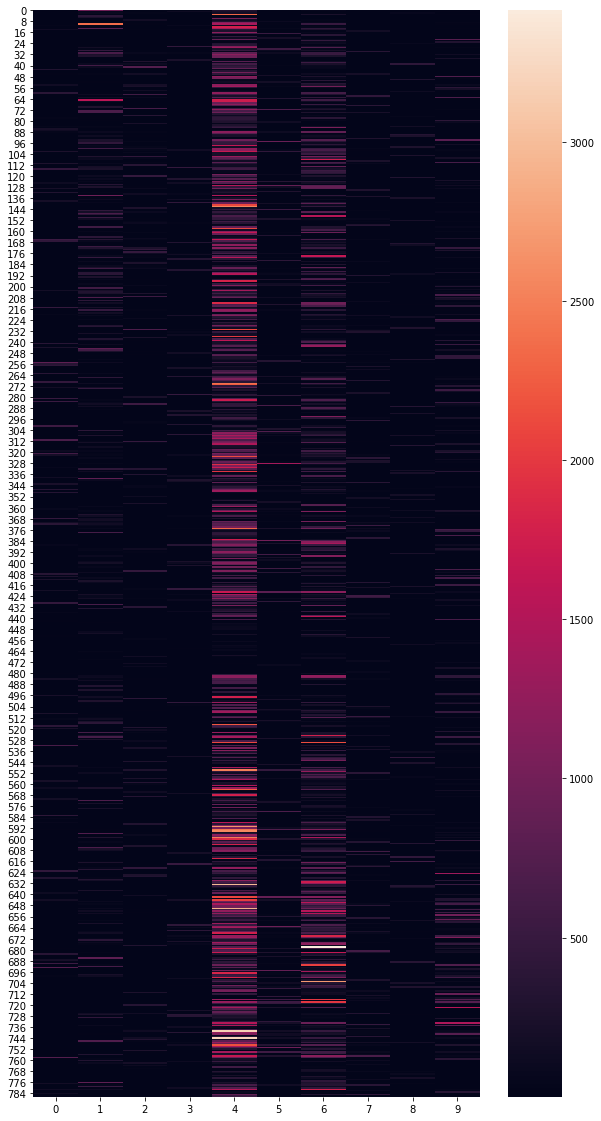

In [44]:
plt.figure(figsize=(10, 20))
sns.heatmap(df)

# Tuning alpha and eta
different parameters. From docstring:
```
`alpha` and `eta` are hyperparameters that affect sparsity of the document-topic
(theta) and topic-word (lambda) distributions. Both default to a symmetric
1.0/num_topics prior.

`alpha` can be set to an explicit array = prior of your choice. It also
support special values of 'asymmetric' and 'auto': the former uses a fixed
normalized asymmetric 1.0/topicno prior, the latter learns an asymmetric
prior directly from your data.

`eta` can be a scalar for a symmetric prior over topic/word
distributions, or a matrix of shape num_topics x num_words, which can
be used to impose asymmetric priors over the word distribution on a
per-topic basis. This may be useful if you want to seed certain topics
with particular words by boosting the priors for those words.  It also
supports the special value 'auto', which learns an asymmetric prior
directly from your data.
```


In [45]:
# example for different specification: repeat analysis 10 times, while learning alpha and eta from the data 
# instead of using 1/number of topics as defailt
lda_m6 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],id2word=id2word_m5,num_topics=50, alpha='auto', eta = 'auto',passes=10)


In [46]:
# with this specific data, this fails b/c of a fitting issue (there is a complex number instead of a float returned somewhere)
vis_data = gensimvis.prepare(lda_m6,ldacorpus_m5,id2word_m5)
pyLDAvis.display(vis_data)

# 8 Plotting over time

Please find here another example that illustrates how to plot topic scores over time, as one example for follow-up analysis.


The `.inference()` method used on the slides and above under chapter 7 gives raw gamma scores (between zero and +infinity). That’s a bit hard to interpret in a plot, so here we will use `.get_document_topics` instead. That will return normalized scores. You can achieve the same result by normalizing the output of `.inference()` yourself (e.g., `normalizedtopicscores = (originalscores.T/originalscores.sum(axis=1)).T`)




In [70]:
filelist = glob('speeches_UK_Cleaned.csv')
print(filelist)
dates = []
speeches_eng=[]
for fn in filelist:
    with open(fn) as fi:
        reader=csv.reader(fi)
        for row in reader:
            if row[7]=='en':   # only include english-language speches; we might as well choose 'nl' or 'fr'
                speeches_eng.append(row[5])
                dates.append(row[1])

['speeches_UK_Cleaned.csv']


In [59]:
speeches=[speech.replace('<p>',' ').replace('</p>',' ') for speech in speeches_eng]   #remove HTML tags
speeches=["".join([l for l in speech if l not in punctuation]) for speech in speeches]  #remove punctuation
speeches=[speech.lower() for speech in speeches]  # convert to lower case

In [60]:
ldainput_m10 = [speech.split() for speech in speeches]           
id2word_m10 = corpora.Dictionary(ldainput_m10)                       

id2word_m10.filter_extremes(no_below=5, no_above=0.5)   # do not consider all words that occur in less than n=5 documents
                                                    # or in more than 50% of all documents.

ldacorpus_m10 = [id2word_m10.doc2bow(doc) for doc in ldainput_m10]
tfidfcorpus_m10 = models.TfidfModel(ldacorpus_m10)
lda_m10 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m10[ldacorpus_m10],id2word=id2word_m10,num_topics=10, passes=5, alpha='auto')


In [62]:
# convert your topics back to a df
all_topics = lda_m10.get_document_topics(ldacorpus_m10, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

all_topics_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000056,0.000056,0.000063,0.000071,0.000058,0.000059,0.999444,0.000057,0.000071,0.000066
1,0.000172,0.000170,0.000192,0.000218,0.000177,0.000181,0.998296,0.000174,0.000218,0.000202
2,0.000204,0.015974,0.000228,0.000258,0.000211,0.000215,0.982207,0.000207,0.000258,0.000239
3,0.000026,0.000026,0.000029,0.000033,0.001315,0.000028,0.998452,0.000026,0.000033,0.000031
4,0.000194,0.000192,0.000217,0.000246,0.000201,0.000205,0.998075,0.000197,0.000246,0.000228


In [63]:
# Divide each value in a row by the sum of the row to normalize the values
all_topics_df.rename(columns= { 0 : "topic_0", 1 : "topic_1", 2 : "topic_2", 3 : "topic_3",
4 : "topic_4", 5 : "topic_5", 6 : "topic_6", 7 : "topic_7", 8 : "topic_8", 9 : "topic_9" },inplace=True)
all_topics_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000056,0.000056,0.000063,0.000071,0.000058,0.000059,0.999444,0.000057,0.000071,0.000066
1,0.000172,0.000170,0.000192,0.000218,0.000177,0.000181,0.998296,0.000174,0.000218,0.000202
2,0.000204,0.015974,0.000228,0.000258,0.000211,0.000215,0.982207,0.000207,0.000258,0.000239
3,0.000026,0.000026,0.000029,0.000033,0.001315,0.000028,0.998452,0.000026,0.000033,0.000031
4,0.000194,0.000192,0.000217,0.000246,0.000201,0.000205,0.998075,0.000197,0.000246,0.000228


In [69]:
dates

[]

In [72]:
### create a df with the dates and orginal texts

meta = pd.DataFrame(zip(dates, speeches_eng))
meta.rename(columns = {0: "date", 1 : "speeches"}, inplace=True)

meta.head()

,date,speeches
0,18-12-2015,<p>This European Council has focused on 3 issu...
1,10-12-2015,<p>Thank you Prime Minister for welcoming me h...
2,09-12-2015,<p>Thank you President Iohannis for welcoming ...
3,07-12-2015,<p>This is a government that delivers</p><p>Th...
4,07-12-2015,"<p>Well thank you very much Prime Minister, th..."


In [73]:
### merge with the topic scores per document

final = pd.concat([meta, all_topics_df], axis=1)
final['id'] = final.index
final.head(3)

,date,speeches,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,id
0,18-12-2015,<p>This European Council has focused on 3 issu...,0.000056,0.000056,0.000063,0.000071,0.000058,0.000059,0.999444,0.000057,0.000071,0.000066,0
1,10-12-2015,<p>Thank you Prime Minister for welcoming me h...,0.000172,0.000170,0.000192,0.000218,0.000177,0.000181,0.998296,0.000174,0.000218,0.000202,1
2,09-12-2015,<p>Thank you President Iohannis for welcoming ...,0.000204,0.015974,0.000228,0.000258,0.000211,0.000215,0.982207,0.000207,0.000258,0.000239,2


In [77]:
### reshape to long format

long = pd.melt(final, id_vars=['id', 'date', 'speeches'], value_vars=[f"topic_{i}" for i in range(0,10)])
long.rename(columns={"variable" : "topic_nr", "value" : "topic_score"}, inplace=True)
long.head(-20)

,id,date,speeches,topic_nr,topic_score
0,0,18-12-2015,<p>This European Council has focused on 3 issu...,topic_0,0.000056
1,1,10-12-2015,<p>Thank you Prime Minister for welcoming me h...,topic_0,0.000172
2,2,09-12-2015,<p>Thank you President Iohannis for welcoming ...,topic_0,0.000204
3,3,07-12-2015,<p>This is a government that delivers</p><p>Th...,topic_0,0.000026
4,4,07-12-2015,"<p>Well thank you very much Prime Minister, th...",topic_0,0.000194
...,...,...,...,...,...
7845,762,01-05-2008,<p>1 May 2008</p><p>The Prime Minister has add...,topic_9,0.000201
7846,763,01-05-2008,<p> Here you will find a selection of non-poli...,topic_9,0.000798
7847,764,08-10-2007,<p>Accompanied by Health Secretary Alan Johnst...,topic_9,0.000752
7848,765,08-10-2007,<p>The Prime Minister has launched the NHS Nex...,topic_9,0.000128


<AxesSubplot:xlabel='date', ylabel='topic_score'>

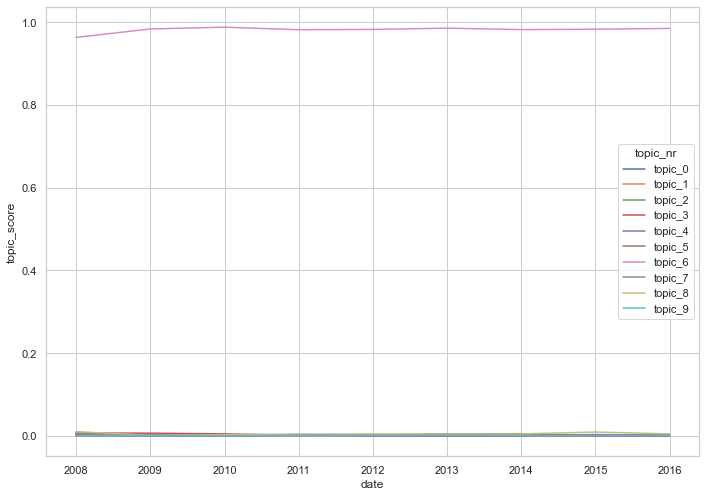

In [75]:
# get data in right shape for plotting

long['date'] = long['date'].map(pd.to_datetime)
plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='Y')]).mean().reset_index()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

sns.lineplot(x="date", y="topic_score", hue="topic_nr", data=plotdf)

In [ ]:
print("FINISHED RUNNING:",str(datetime.now()))